In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
import math

In [3]:
def neutrino_rate(E, costheta, dm2 = 2.4*10**-3, sin2_2theta = 0.9):
    flux = 10**(5) * E**(-1.7)
    L = 12*10**3 * costheta  # 2 * earth radius ~ 12*10**3 km
    prob_osc = 1 - sin2_2theta * (np.sin(1.27*dm2*L/E))**2

    return flux*prob_osc


In [4]:
def experiment_sim(nbinsE, nbinsAngle):
    # these are our energy and costheta bins
    energy = 10**np.linspace(1,2,nbinsE)
    costheta = np.linspace(0,1,nbinsAngle) 

    # generate simulation as Gaussian (or Poissonian) with mean given by the "theoretical" rate and with width given by the Poissonian standard deviation of the rate (counting experiment)
    rate_means = np.array([neutrino_rate(e,c) for e in energy for c in costheta])
    rate_widths = np.sqrt(rate_means)

    #simulated_rate = np.random.normal(rate_means, rate_widths)
    simulated_rate = np.random.poisson(rate_means)
    modif_energy = np.repeat(energy, repeats=nbinsAngle)
    modif_costheta = np.tile(costheta,nbinsE)
    events = pd.DataFrame({"Energy": modif_energy, "CosTheta": modif_costheta, "Nevts": simulated_rate})
    return events

events = experiment_sim(10,10)
events

,Energy,CosTheta,Nevts
0,10.0,0.000000,1913
1,10.0,0.111111,1703
2,10.0,0.222222,1101
3,10.0,0.333333,403
4,10.0,0.444444,222
...,...,...,...
95,100.0,0.555556,34
96,100.0,0.666667,41
97,100.0,0.777778,31
98,100.0,0.888889,42


In [5]:
# setting up chi^2 function for binned data
def chi2(params, events):
    dm2, sin2_2theta = params
    chi2 = np.sum((events["Nevts"] - neutrino_rate(events["Energy"], events["CosTheta"], dm2, sin2_2theta))**2 / events["Nevts"])
    return chi2

In [6]:
# minimize chi^2
fit = scp.optimize.minimize(chi2, args=events, x0=[1*10**(-4), 0.1], method='Nelder-Mead')
fit

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 87.41161283240176
             x: [ 2.405e-03  8.993e-01]
           nit: 53
          nfev: 102
 final_simplex: (array([[ 2.405e-03,  8.993e-01],
                       [ 2.405e-03,  8.993e-01],
                       [ 2.405e-03,  8.993e-01]]), array([ 8.741e+01,  8.741e+01,  8.741e+01]))

In [7]:
fit_dm2 = fit.x[0]
fit_sin2 = fit.x[1]

In [102]:
# calculate uncertainty with error propagation from bin populations!
n = 0
dy = 0.0
for i in range(0,100):
    if events["CosTheta"][i] > 0.0:
        dy += np.sqrt(events["Nevts"][i] / (events["Nevts"][i]*10**5*events["Energy"][i]**(-1.7)*(np.sin(1.27*fit.x[0]*12*10**3*events["CosTheta"][i]))**2)**2)
        n += 1
       # print('iteration: ', i, '\t dy: ', events["Nevts"][i] / (10**5*events["Energy"][i]**(-1.7)*(np.sin(1.27*fit.x[1]*12*10**3*events["CosTheta"][i]))**2)**2)

ds = dy/n
ds

0.0041415049238898915

In [88]:
m=0
dx=0.0
for i in range(0,100):
    if events["CosTheta"][i] > 0.1 and (1-(events["Nevts"][i]/(10**5 * events["Energy"][i]**(-1.7)))) > 0:
#        print(i, " ", ((events["Energy"][i])/(1.27**2 *2*12*10**3 * events["CosTheta"][i] * 10**5 * events["Energy"][i]**(-1.7) * ((1/fit.x[1])*(1- (events["Nevts"][i]/(10**5 * events["Energy"][i]**(-1.7)))))**(0.75)))**2)
        dx += np.sqrt(events["Nevts"][i]*((events["Energy"][i])/(events["Nevts"][i]*1.27**2 *2*12*10**3 * events["CosTheta"][i] * 10**5 * events["Energy"][i]**(-1.7) * ((1/fit.x[1])*(1- (events["Nevts"][i]/(10**5 * events["Energy"][i]**(-1.7)))))**(0.75))**2))
        m += 1

dt = dx/m
dt

2.2302897170433257e-06

In [13]:
experiments = np.array([experiment_sim(10,10) for i in range(0,1000)])
fits = np.array([scp.optimize.minimize(chi2, args=pd.DataFrame(experiments[i], columns = ["Energy", "CosTheta", "Nevts"]), x0=[1*10**(-4), 0.1], method='Nelder-Mead') for i in range(0,1000)])

In [14]:
fitted_dm2 = np.array([fits[i].x[0] for i in range(0,1000)])

In [15]:
fitted_sin2_2theta = np.array([fits[i].x[1] for i in range(0,1000)])

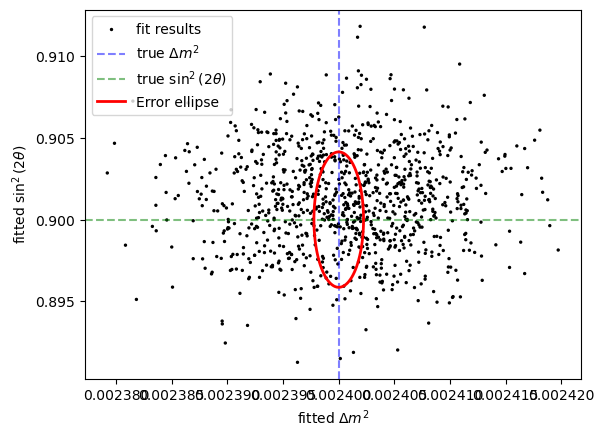

In [99]:
e = np.linspace(0, 2*math.pi, 100)
plt.scatter(fitted_dm2, fitted_sin2_2theta, color='black', label="fit results", sizes=2*np.ones(1000))
plt.axvline(x=2.4*10**-3, color='blue', alpha=0.5, label='true $\\Delta m^{2}$', linestyle='--')
plt.axhline(y=0.9, color='green', alpha=0.5, label='true $\\sin^{2}(2\\theta)$', linestyle='--')
#plt.plot( 2.4*10**(-3)+(perr[0]*1/np.sqrt(out.res_var))*np.cos(t) , 0.9+(perr[1]*1/np.sqrt(out.res_var))*np.sin(t), label = 'Error ellipse', lw = 2, color='red')
plt.plot( 2.4*10**(-3)+dt*np.cos(e) , 0.9+ds*np.sin(e), label = 'Error ellipse', lw = 2, color='red')
plt.ylabel('fitted $\\sin^{2}(2\\theta)$')
plt.xlabel('fitted $\\Delta m^{2}$')
plt.legend()

In [105]:
count = 0
#for bin in range(0,fitted_dm2.size):
#    if fitted_dm2[bin] < 2.4*10**(-3)+dt and fitted_dm2[bin] > 2.4*10**(-3)-dt and fitted_sin2_2theta[bin] < 0.9+ds and fitted_sin2_2theta[bin] > 0.9-ds:
#        count += 1

for bin in range(0,fitted_dm2.size):
    if ((fitted_dm2[bin]-2.4*10**(-3))**2/(dt)**2) + ((fitted_sin2_2theta[bin]-0.9)**2/(ds)**2) < 1.0:
        count += 1

print('fraction inside uncertainty ellipse: ', count/fitted_dm2.size)

fraction inside uncertainty ellipse:  0.159
